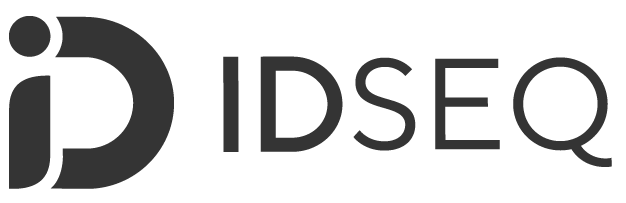

# short-read-mngs benchmark

Load notebook parameters from environment variables:

* `RUN_NAME`: descriptive name for these results
* `HARVEST_DATA`: filename containing JSON output of harvest.py (multiple files colon-separated)
* `REF_LIB`: directory containing SAMPLE.json files with reference (expected) data for each sample
* `MIN_RPM`: rPM cutoff for display in this notebook's detail tables

In [ ]:
import os
def param(key, default):
    value = os.environ.get(key, default)
    print(f"{key} = {value}")
    return value
run_name = param("RUN_NAME", "short-read-mngs")
datafiles = param("HARVEST_DATA", "harvest.json")
reference_lib = param("REF_LIB", None)
min_rPM = int(param("MIN_RPM", 500))

In [ ]:
import json
import math
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, HTML

In [ ]:
data = {}
for datafile in datafiles.split(":"):
    if datafile:
        with open(datafile) as infile:
            data.update(json.load(infile))
ref_data = {}
if reference_lib:
    for sample in data:
        ref_fn = os.path.join(reference_lib, f"{sample}.json")
        if os.path.isfile(ref_fn):
            with open(ref_fn) as infile:
                ref_data[sample] = json.load(infile)
        else:
            print(f"WARNING: no reference data for {sample}")

In [ ]:
# master routine for color-coding deviations and touching a sentinel file if any exist
SENTINEL_FN = ".short-read-mngs-benchmarks-deviation"
try:
    os.remove(SENTINEL_FN)
except FileNotFoundError:
    pass
def colorcode(err):
    ans = 'green'
    if not isinstance(err, float) or math.isnan(err) or err > 0.01:
        ans = 'red'
        if isinstance(err, float) and err <= 0.1:
            ans = 'yellow'
        with open(SENTINEL_FN, 'w'):
            pass
    return ans

## read & contig summary counts

In [ ]:
counts_df = pd.DataFrame.from_dict({sample: elt["counts"] for sample, elt in data.items()})
if ref_data:
    ref_df = pd.DataFrame.from_dict({f"{sample}.REF": elt["counts"] for sample, elt in ref_data.items()})
    counts_df = pd.concat([counts_df, ref_df], axis=1)
    counts_df = counts_df.reindex(sorted(counts_df.columns), axis=1)
    def error_colors(counts_df):
        colors_df = pd.DataFrame('', index=counts_df.index, columns=counts_df.columns)
        for sample in data:
            for key in counts_df.index:
                err = float("nan")
                v = counts_df[sample][key]
                try:
                    vref = ref_df[f"{sample}.REF"][key]
                    if isinstance(v, (int, float)):
                        err = math.fabs((v-vref)/vref)
                    elif v == vref:
                        err = 0
                except KeyError:
                    pass
                color = colorcode(err)
                colors_df[sample][key] = 'background-color: light' + color
                colors_df[f"{sample}.REF"][key] = 'background-color:' + color
        return colors_df
    counts_df = counts_df.style.apply(error_colors, axis=None)

**Below:**

1. "{stage}_reads" counts reads *output* by the stage.
  * If the input is paired, then they count pairs.
1. "{initial,refined}_unmapped_reads" count reads unassigned to any taxa in NT or NR, before and after remapping to assembly contigs.
  * These always count individual reads (never pairs).
1. "{sample}.REF" columns show the respective count from the reference library, if supplied.
  * green = within 1% of reference, yellow = within 10%, red = other.

In [ ]:
pd.set_option("display.precision", 2)
display(counts_df)

## taxa abundance spectra & tables

In [ ]:
def taxa_dataframe(sample_data, sample_reads, db):
    # for one sample and either NR or NT, generate dataframe of the taxa-specific abundance/assembly info
    prep = {}
    for tax_id in sample_data:
        sample_data[tax_id]["rPM"] = max(1,round(sample_data[tax_id]["reads_dedup"]*1e6/sample_reads))
        prep[tax_id] = {f"{db}_{key}": sample_data[tax_id][key] for key in [
            "tax_name", "rPM", "reads", "contigs_reads", "contigs_N50"]}
    return pd.DataFrame.from_dict(prep, orient="index")

def joined_taxa_dataframe(sample_data):
    # figure rPM denominator
    sample_reads = sample_data["counts"]["gsnap_filter_reads"]
    if sample_data["counts"]["paired"]:
        sample_reads *= 2

    # taxa dataframes for NT & NR
    sample_NT = taxa_dataframe(sample_data["taxa"]["NT"], sample_reads, "NT")
    sample_NR = taxa_dataframe(sample_data["taxa"]["NR"], sample_reads, "NR")

    # join them & reformat
    joined = pd.merge(sample_NT, sample_NR, how="outer", left_index=True, right_index=True)
    joined["tax_name"] = joined["NT_tax_name"].combine_first(joined["NR_tax_name"])
    joined["max_rPM"] = joined[["NT_rPM", "NR_rPM"]].max(axis=1)
    
    return joined[[
        "tax_name", "max_rPM",
        "NT_contigs_reads", "NT_contigs_N50",
        "NR_contigs_reads", "NR_contigs_N50"
    ]].sort_values(by="max_rPM", ascending=False)

taxa_tables = {}
for sample, sample_data in data.items():
    joined = joined_taxa_dataframe(sample_data)
    if ref_data:
        if sample in ref_data:
            joined_ref = joined_taxa_dataframe(ref_data[sample])
        else:
            joined_ref = pd.DataFrame(columns=joined.columns)
        joined_ref = joined_ref.rename(columns={key: f"{key}.REF" for key in joined_ref.columns})
        joined = pd.merge(joined, joined_ref, how="outer", left_index=True, right_index=True)
        joined["tax_name"] = joined["tax_name"].combine_first(joined["tax_name.REF"])
        joined = joined.drop(columns="tax_name.REF")
        joined = joined.reindex(list(dict.fromkeys(["tax_name", "max_rPM", "max_rPM.REF"] + sorted(joined.columns))), axis=1)
    taxa_tables[sample] = joined
    
pd.set_option("display.max_rows", None)
def error_colors(joined):
    colors_df = pd.DataFrame('', index=joined.index, columns=joined.columns)
    for measure in ["max_rPM",
            "NT_contigs_reads", "NT_contigs_N50",
            "NR_contigs_reads", "NR_contigs_N50"]:
        for taxon in joined.index:
            v = joined[measure][taxon]
            vref = joined[f"{measure}.REF"][taxon]
            if (math.isnan(v) and math.isnan(vref)) or v == vref:
                err = 0.0
            else:
                err = math.fabs((v-vref)/vref)
            color = colorcode(err)
            colors_df[measure][taxon] = 'background-color: light' + color
            colors_df[f"{measure}.REF"][taxon] = 'background-color:' + color
    return colors_df

**Below, for each sample:**

1. abundance spectrum: empirical CDF of log10(max_rPM) for all species output by the pipeline.
  * max_rPM = max between NR & NT
  * red line: MIN_RPM cutoff for display in subsequent table.
2. table of each species above MIN_RPM, with read & contig stats for NR & NT
  * green = within 1% of reference, yellow = within 10%, red = other.

In [ ]:
for sample, joined in taxa_tables.items():
    display(HTML(f"<h3>{sample}</h3>"))
    ax = sns.ecdfplot(data=np.log10(joined["max_rPM"]))
    plt.axvline(math.log10(min_rPM), 0, 1, color='r', linestyle='--')
    ax.set(xlabel="log_10(max(NT_rPM,NR_rPM))")
    plt.show()
    pd.set_option("display.precision", 0)
    joined = joined[joined["max_rPM"] >= min_rPM]
    if ref_data:
        joined = joined.style.apply(error_colors, axis=None)
    display(joined)

## Appendix: raw workflow outputs

In [ ]:
for sample in data:
    display(HTML(f"<h3>{sample}</h3>"))
    print(json.dumps(data[sample]["outputs"], indent=2))